# Prolific AI Interviewer — LangGraph Walkthrough

This notebook walks through the production interview workflow node by node. It runs the same LangGraph agent that powers the FastAPI service, using live OpenAI calls for question generation and grading so you can observe each confidence update in context.


## Prerequisites
- Install project dependencies (`uv sync` or `pip install -e .`).
- Export a valid `OPENAI_API_KEY` (the notebook stops early if the key is missing).
- Run from the repository root so `src/` is importable.


In [21]:
import sys
from pathlib import Path

root = Path.cwd()
src_dir = root / 'src'
if src_dir.exists() and str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))


# Step 0 - Initial Setup 

In [22]:
import os
from dotenv import load_dotenv

load_dotenv()
if not os.getenv("OPENAI_API_KEY"):
    raise EnvironmentError("OPENAI_API_KEY is required for live LLM calls. Set it in your environment or .env file before running these cells.")


from app.core.config import get_settings

settings = get_settings()
print("✅ Environment ready — using live OpenAI calls.")
print(f"Model: {settings.openai_model}  Temperature: {settings.openai_temperature}")


✅ Environment ready — using live OpenAI calls.
Model: gpt-4o-mini  Temperature: 0.4


## Step 1 · Define a Candidate Profile
Provide the same data structure the FastAPI service receives. The helpers in `src/app/service/utils/profile.py` map these fields into skills and evidence spans.


In [23]:
profile = {
    "CANDIDATE_NAME": "Casey Graph",
    "ROLE": "Applied ML Engineer",
    "SKILLS": [
        {
            "taxonomy_id": "machine_learning/pytorch",
            "evidence_sources": [
                {"span": "Led fine-tuning of vision transformers for embedded devices."},
                {"span": "Shipped training pipelines on distributed GPUs."}
            ],
        },
        {
            "taxonomy_id": "machine_learning/langchain-evals",
            "evidence_sources": [
                {"span": "Built eval harnesses for LLM agents measuring precision/recall."}
            ],
        },
        {
            "taxonomy_id": "machine_learning/cuda",
            "evidence_sources": [
                {"span": "Optimised CUDA kernels for low-latency inference."}
            ],
        },
    ],
}
print(f"Profile includes {len(profile['SKILLS'])} claimed skills.")


Profile includes 3 claimed skills.


## Step 2 · Build the Initial Interview State
We call `build_state` exactly like the service: this seeds the priors, UCB/LCB thresholds, and log buffer. `render_skills` mirrors the Streamlit summary table.



In [34]:
from app.agents.interviewer.graph import build_state
from app.service.utils.profile import derive_skills_from_profile, build_spans_map_from_profile
from app.agents.interviewer.utils.state import summarise_skills
from IPython.display import display

skills = derive_skills_from_profile(profile)
spans_map = build_spans_map_from_profile(profile)

max_turns = 10 # Maximum number of turns in the interview
min_questions = 3 # Minimum number of questions to ask
verification_threshold = 3.5 # Minimum score to verify a skill
z_value = 1.64 # Z-value for confidence interval 90%
ucb_c = 2.0 # UCB confidence parameter (higher = more exploration) -> Here we are encouraging exploration

state = build_state(
    skills,
    max_turns,
    min_questions,
    verification_threshold,
    z_value,
    ucb_c,
    spans_map,
)

def render_skills(state):
    rows = summarise_skills(state)
    for row in rows:
        print(row)
    return rows

print(f"Initial skills: {skills}")
_ = render_skills(state) 

Initial skills: ['pytorch', 'langchain-evals', 'cuda']
{'skill': 'pytorch', 'status': 'probing', 'n': 0, 'mean': 2.5, 'se': 1.225, 'lcb': 0.49}
{'skill': 'langchain-evals', 'status': 'probing', 'n': 0, 'mean': 2.5, 'se': 1.225, 'lcb': 0.49}
{'skill': 'cuda', 'status': 'probing', 'n': 0, 'mean': 2.5, 'se': 1.225, 'lcb': 0.49}


## Step 3 · Generate Seed Questions with the LLM
`generate_questions_node` seeds one question per skill so the loop has a fallback even if later LLM calls fail. Each request now includes a short history snippet so follow-ups stay aware of what the candidate already said.


In [35]:
from app.agents.interviewer.nodes.generate import generate_questions_node

state = await generate_questions_node(state)
print(f"Seeded {len(state['question_pool'])} questions.")
for q in state["question_pool"]:
    print(f"- {q.skill} (d={q.difficulty}): {q.text}")


Seeded 3 questions.
- pytorch (d=3): Explain how you would implement a custom loss function in PyTorch and provide a brief example of its usage in a training loop.
- langchain-evals (d=3): How would you implement a custom evaluation metric in LangChain to assess the performance of a language model on a specific task, such as summarization or question answering?
- cuda (d=3): What strategies would you employ to optimize memory access patterns in a CUDA kernel to improve performance, and why are they effective?


## Step 4 · Select the Next Skill via UCB and Prepare the Follow-up
`select_question_node` scores every active skill with Upper Confidence Bound (mean + exploration bonus), skipping anything already verified or marked inactive. The LLM sees the prior question, grading rationale, and a blunt history transcript so it can chain context-aware follow-ups.


In [36]:
from app.agents.interviewer.nodes.select import select_question_node
from app.agents.interviewer.nodes.ask import ask_node

state = await select_question_node(state)
state = ask_node(state)

current_question = state["current_question"]
print(f"Selected skill: {current_question.skill}")
print(f"Question difficulty ({current_question.difficulty}/5): {current_question.text}\n")
print("Recent UCB logs:")
for log in state["logs"][-3:]:
    print(" •", log)


Selected skill: pytorch
Question difficulty (3/5): Explain how you would implement a custom loss function in PyTorch and provide a brief example of its usage in a training loop.

Recent UCB logs:
 • select_question → [pytorch] d=3 Explain how you would implement a custom loss function in Py...
 • select_question → source=pool
 • ask → pytorch: Explain how you would implement a custom loss function in PyTorch and provide a 


## Step 5 · Capture a Candidate Answer
Replace the generated answer with human input if you are running a live interview. Here we call the same OpenAI model for a sample response.


In [37]:
from app.core.llm import get_llm

answer_llm = get_llm(temperature=1)
answer_prompt = (
    "You are a candidate in a technical interview. Answer this interview question as someone proficient in "
    "langchain-evals but unfamiliar with pytorch and cuda. If the question involves pytorch/cuda concepts you don't know, "
    "be honest about your limitations rather than attempting solutions. Keep your response focused and under 3 sentences.\n\n"
    f"Question: {current_question.text}"
)
answer_message = await answer_llm.ainvoke(answer_prompt)
candidate_answer = answer_message.content.strip()

print(candidate_answer)


I'm proficient in LangChain evaluations but unfamiliar with PyTorch and CUDA, so I can't provide a detailed implementation of a custom loss function. However, I understand that typically, you'd define the loss function by subclassing `torch.nn.Module` and overriding the `forward` method. For specific syntax and usage within a training loop, I recommend referring to PyTorch documentation or resources.


## Step 6 · Grade the Answer and Update the Belief State
`grade_node` calls the LLM grader. `update_node` then runs Welford's incremental stats, recomputes the lower confidence bound (LCB), and updates verified/inactive flags.


In [38]:
from app.agents.interviewer.nodes.grade import grade_node
from app.agents.interviewer.nodes.update import update_node

state["pending_answer"] = candidate_answer
state = await grade_node(state)

grade = state["last_grade"]
print(f"LLM score: {grade.score}/5")
print(f"Reasoning: {grade.reasoning}")

state = update_node(state)
_ = render_skills(state)


LLM score: 1/5
Reasoning: The response fails to provide any implementation details for a custom loss function in PyTorch, which is the core of the question. Additionally, the mention of being unfamiliar with PyTorch and CUDA indicates a lack of relevant knowledge, leading to a score of 1.
{'skill': 'pytorch', 'status': 'inactive', 'n': 1, 'mean': 2.0, 'se': 0.866, 'lcb': 0.58}
{'skill': 'langchain-evals', 'status': 'probing', 'n': 0, 'mean': 2.5, 'se': 1.225, 'lcb': 0.49}
{'skill': 'cuda', 'status': 'probing', 'n': 0, 'mean': 2.5, 'se': 1.225, 'lcb': 0.49}


### Confidence Math Explained
- **Welford update** keeps a running mean and spread with one sample at a time—no need to store every score.
- **Standard error guardrail** keeps early intervals fat (min 0.25) so one good answer does not trick us into blind confidence.
- **Lower Confidence Bound (LCB)** = mean − *z* × standard error. Once LCB beats the threshold, the skill is considered verified.
- **Upper Confidence Bound (UCB)** = mean + exploration bonus. It favours believable skills but still rotates through under-sampled ones.


#### Worked Example
Walk through what happens to one skill after repeated answers.
1. **Priors**: we inject two pseudo-samples at mean 2.5 with variance 1.5. Standard error starts ≈ 1.22, giving an ultra-cautious LCB ≈ 0.11.
2. **First answer (score 4)**: Welford folds in the score, mean → 3.00 (weighted with priors) and se stays ≈ 1.22; LCB ≈ 0.61—still far below the 3.75 verification bar.
3. **Second answer (score 4)**: mean creeps toward 3.5, variance tightens, se ≈ 0.70, LCB ≈ 2.13.
4. **Third answer (score 4)**: real_n=3, se floor lifts, se ≈ 0.46 so LCB rises to ≈ 3.10. Only after several strong answers does it cross 3.75.
5. **Missed answer (score 2)**: mean drops and variance widens, pulling LCB right back down—one weak turn quickly erodes confidence.
6. **UCB term**: default “ucb1” mode adds `C * sqrt(log(t) / n_real)` so under-sampled skills get revisited. Switch to `mode='se'` to use `C * se` when you prefer exploration tied to statistical uncertainty.


In [46]:
from app.agents.interviewer.utils.stats import (
    compute_uncertainty,
    effective_sample_count,
    ensure_prior,
    welford_update,
)

def describe(scores, z=1.64):
    belief = {}
    ensure_prior(belief)
    compute_uncertainty(belief, z, add_ucb=True)
    print(f"n={effective_sample_count(belief)} → mean={belief['mean']:.2f}, se={belief['se']:.2f}, LCB={belief['lcb']:.2f}")
    for score in scores:
        welford_update(belief, score)
        compute_uncertainty(belief, z, add_ucb=True)
        print(f"n={effective_sample_count(belief)} → mean={belief['mean']:.2f}, se={belief['se']:.2f}, LCB={belief['lcb']:.2f}")

print('Two consistent scores of 4:')
describe([4, 4, 5, 5,5,5,5])

print('Add a weaker score of 2:')
describe([5, 2, 2])


Two consistent scores of 4:
n=0 → mean=2.50, se=1.22, LCB=0.49
n=1 → mean=3.00, se=0.87, LCB=1.58
n=2 → mean=3.25, se=0.66, LCB=2.17
n=3 → mean=3.60, se=0.62, LCB=2.58
n=4 → mean=3.83, se=0.56, LCB=2.92
n=5 → mean=4.00, se=0.50, LCB=3.18
n=6 → mean=4.12, se=0.45, LCB=3.39
n=7 → mean=4.22, se=0.41, LCB=3.55
Add a weaker score of 2:
n=0 → mean=2.50, se=1.22, LCB=0.49
n=1 → mean=3.33, se=1.09, LCB=1.54
n=2 → mean=3.00, se=0.84, LCB=1.62
n=3 → mean=2.80, se=0.68, LCB=1.68


## Step 7 · Decide Whether to Continue
`decide_node` stops once we hit the turn cap, all skills are verified, or nothing is left to probe.


In [47]:
from app.agents.interviewer.nodes.decide import decide_node

command = decide_node(state)
print(f"Next action: {command.goto}")

print("\nLatest logs:")
for entry in state["logs"][-8:]:
    print(" •", entry)


Next action: select

Latest logs:
 • select_ucb → → select pytorch (UCB=4.165)
 • select_question → [pytorch] d=3 Explain how you would implement a custom loss function in Py...
 • select_question → source=pool
 • ask → pytorch: Explain how you would implement a custom loss function in PyTorch and provide a 
 • grade → 1 (The response fails to provide any implementation details for a custom loss function in PyTorch, which is the core of the question. Additionally, the mention of being unfamiliar with PyTorch and CUDA indicates a lack of relevant knowledge, leading to a score of 1.)
 • update → pytorch: n=1 mean=2.00 SE=0.866 LCB=0.58
 • status → verified=False inactive=True
 • decide → continue


## Step 8 · Running Additional Turns (Optional)
Wrap the steps above in a helper to simulate a full interview. Swap in human answers to mirror the service loop.



=== Turn 1 ===

Next skill: pytorch
Question (3/5): Can you explain how you would implement gradient accumulation in PyTorch to effectively train a model with a larger effective batch size without exceeding GPU memory limits?

Candidate answer:
I'm not familiar with PyTorch or CUDA, so I can't provide specific implementation details for gradient accumulation in that framework. However, I understand that gradient accumulation involves updating the model weights after accumulating gradients over multiple forward passes, which allows for simulating a larger batch size without increasing memory usage. If you need detailed code or specific functions, I would recommend consulting PyTorch documentation or resources focused on that topic.

LLM score: 1/5
Reasoning: The response indicates a lack of familiarity with PyTorch and CUDA, which is a critical requirement for addressing the question. While it correctly identifies the concept of gradient accumulation, it fails to provide any specific i

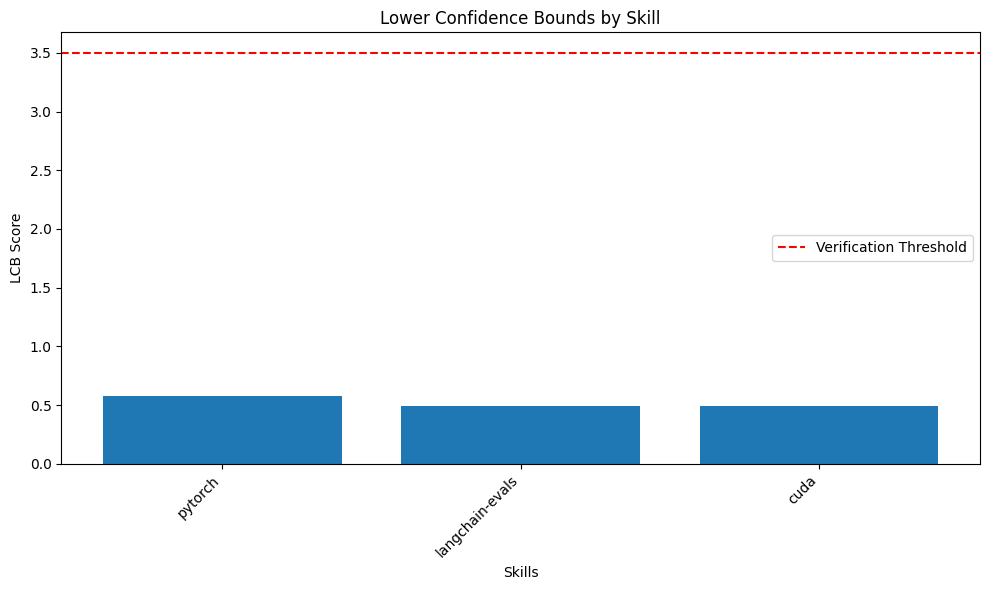


=== Turn 2 ===

Next skill: langchain-evals
Question (2/5): Can you describe a scenario where you would use langchain-evals to evaluate the performance of a language model, and explain how you would set up the evaluation metrics?

Candidate answer:
I would use langchain-evals to evaluate a language model's performance in a chatbot application by assessing metrics such as accuracy, relevance, and user satisfaction. To set up the evaluation, I would define a set of test prompts and expected responses, then use langchain-evals to compare the model's outputs against these benchmarks, calculating metrics like precision and recall. This structured approach helps ensure the model meets the desired performance standards in real-world interactions.

LLM score: 4/5
Reasoning: The response accurately describes a scenario for using langchain-evals in a chatbot application and identifies relevant evaluation metrics such as accuracy, relevance, and user satisfaction. It also outlines a structured a

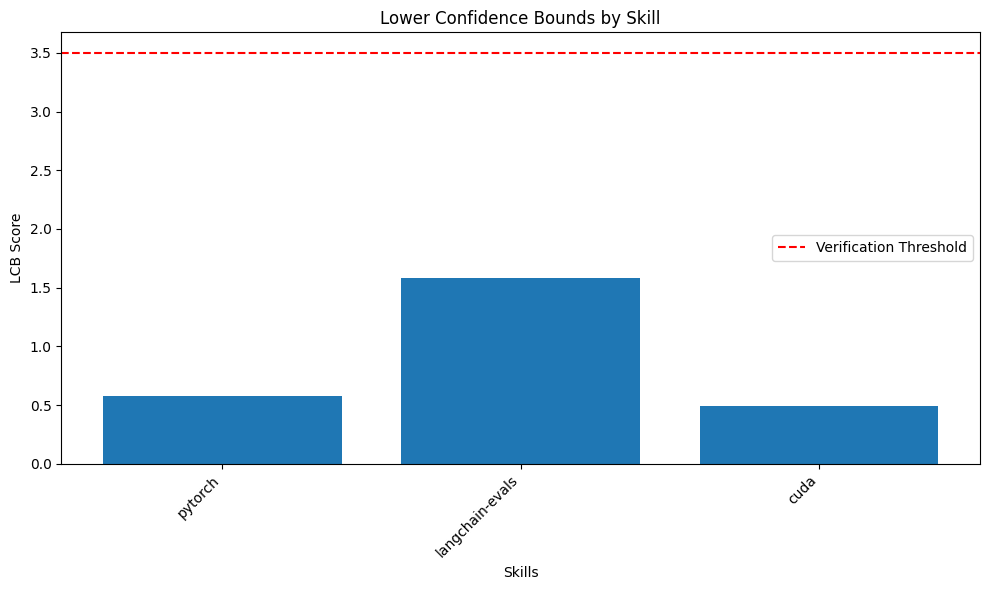


=== Turn 3 ===

Next skill: langchain-evals
Question (4/5): How would you implement a custom evaluation metric using langchain-evals to assess the performance of a language model in a specific application, and what factors would you consider in its design?

Candidate answer:
To implement a custom evaluation metric using langchain-evals, I would define the metric as a function that takes model outputs and reference outputs, then computes a score based on the specific requirements of the application, such as accuracy or relevance. Key factors to consider in its design include the specific goals of the application, the types of errors to penalize, and how to balance precision and recall based on user needs. Since I'm not familiar with PyTorch or CUDA, I would focus on the logic of the metric itself rather than any underlying implementations related to those technologies.

LLM score: 3/5
Reasoning: The response outlines a basic approach to implementing a custom evaluation metric, mentioni

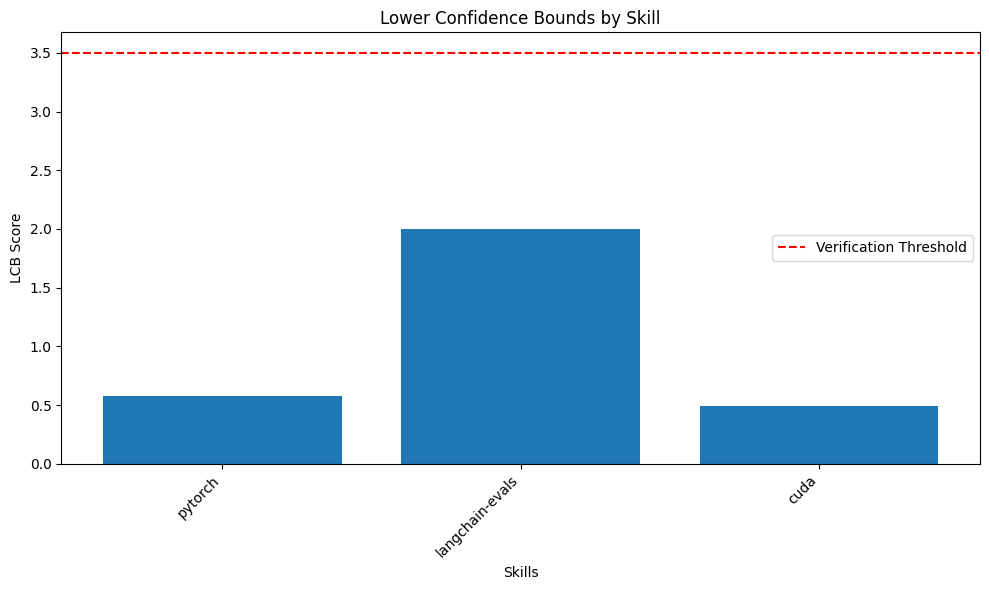


=== Turn 4 ===

Next skill: cuda
Question (3/5): How would you optimize a CUDA kernel for low-latency inference in a neural network application, and what specific techniques would you apply to improve performance?

Candidate answer:
I appreciate the question, but my expertise lies primarily in LangChain and evaluation frameworks rather than in CUDA or PyTorch. I am not familiar with specific techniques for optimizing CUDA kernels for low-latency inference. However, I can discuss strategies for evaluating model performance and efficiency within the LangChain framework if that would be helpful.

LLM score: 1/5
Reasoning: The response fails to address the question regarding CUDA kernel optimization for low-latency inference, indicating a lack of knowledge in the required area. It is irrelevant and does not provide any specific techniques or insights related to CUDA, which is essential for a passing score.
{'skill': 'pytorch', 'status': 'inactive', 'n': 1, 'mean': 2.0, 'se': 0.866, 'lcb':

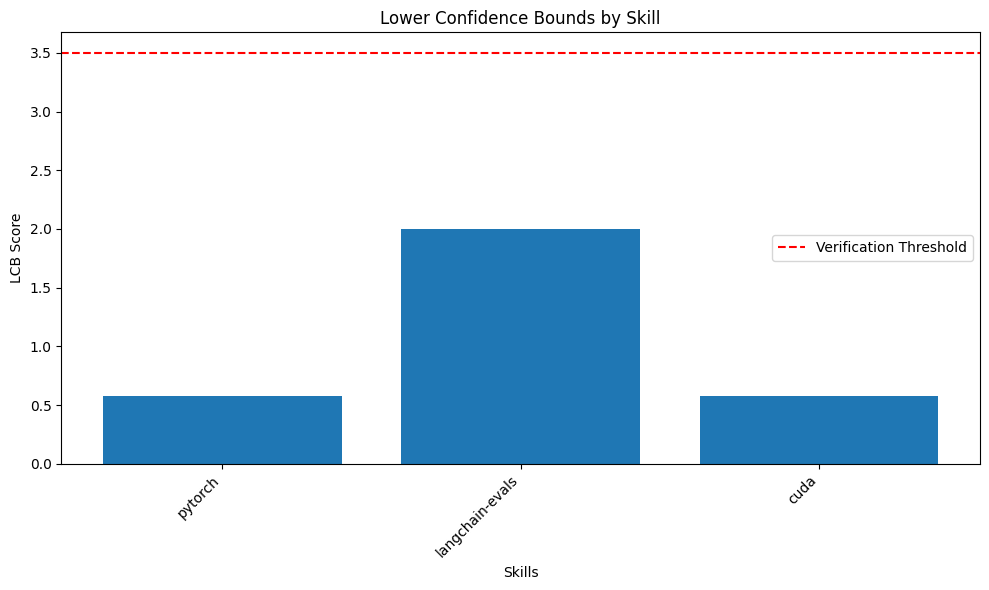


=== Turn 5 ===

Next skill: langchain-evals
Question (2/5): How would you use langchain-evals to compare the performance of two different language models on a specific task, and what key metrics would you focus on in your evaluation?

Candidate answer:
To compare the performance of two different language models using langchain-evals, I would set up an evaluation framework that defines the specific task and utilizes the built-in evaluation functions to assess each model's outputs. Key metrics I would focus on include accuracy, F1 score, and response relevance, depending on the task's nature. While I'm proficient in langchain-evals, I don't have experience with PyTorch or CUDA, so I would rely on the langchain-evals documentation for any model integration specifics.

LLM score: 3/5
Reasoning: The response correctly identifies the need for an evaluation framework and mentions relevant metrics like accuracy, F1 score, and response relevance. However, it lacks specific implementation detai

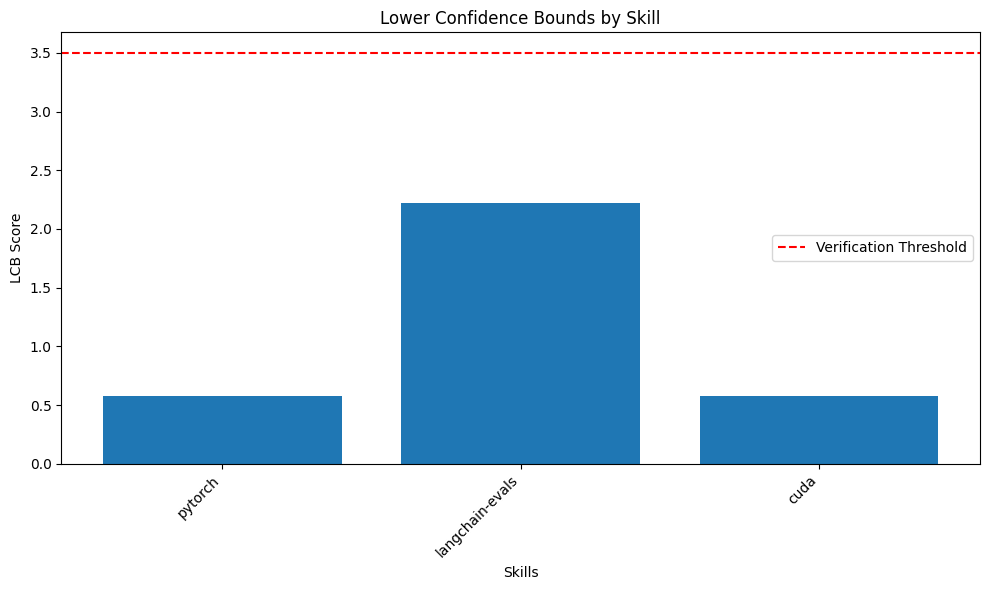


=== Turn 6 ===

Next skill: langchain-evals
Question (3/5): What steps would you take to implement a custom evaluation metric in langchain-evals for a text classification task, and how would you validate its effectiveness?

Candidate answer:
To implement a custom evaluation metric in langchain-evals for a text classification task, I would first define the metric function that computes the desired evaluation criteria based on the model's predictions and the true labels. Next, I would integrate this function into the evaluation pipeline of langchain-evals, ensuring it is called during the evaluation process. To validate its effectiveness, I would compare the results of this custom metric against established metrics (like accuracy or F1 score) on a validation dataset to ensure it aligns with expected outcomes.

LLM score: 4/5
Reasoning: The response outlines a clear process for implementing a custom evaluation metric, including defining the metric function and integrating it into the eva

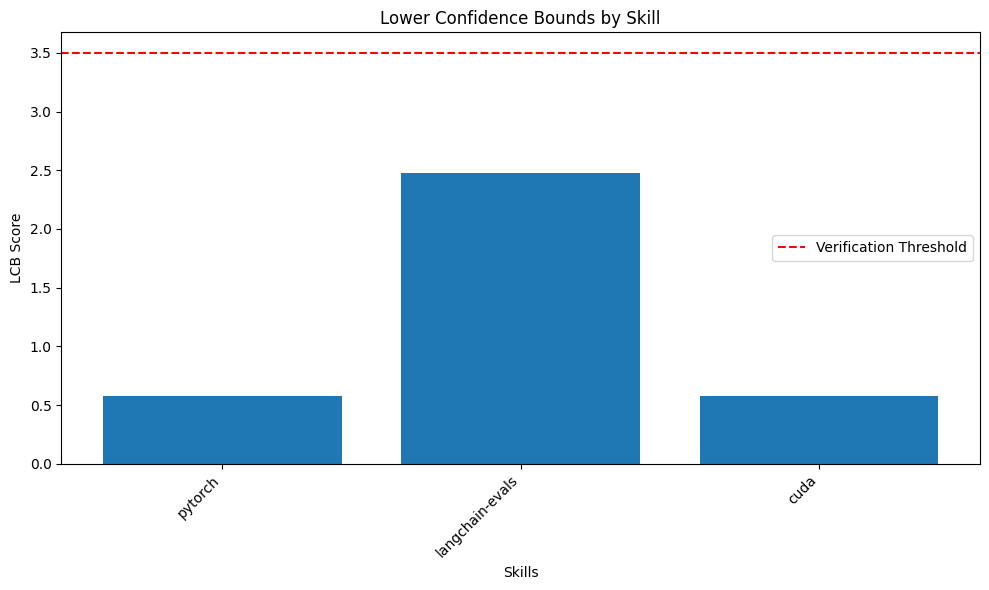


=== Turn 7 ===

Next skill: langchain-evals
Question (4/5): How would you approach the implementation of a custom evaluation metric in langchain-evals to assess the performance of a language model on a specific task, and what key considerations would guide your design?

Candidate answer:
To implement a custom evaluation metric in langchain-evals, I would first define the specific criteria that reflect the performance of the language model on the task, such as accuracy, relevance, or coherence. Then, I would create a function that computes this metric based on the model's outputs and the expected results, ensuring it integrates seamlessly with the existing evaluation framework. Key considerations would include the metric's interpretability, computational efficiency, and how well it aligns with the goals of the task being evaluated.

LLM score: 4/5
Reasoning: The response demonstrates a strong understanding of the steps needed to implement a custom evaluation metric in langchain-evals, 

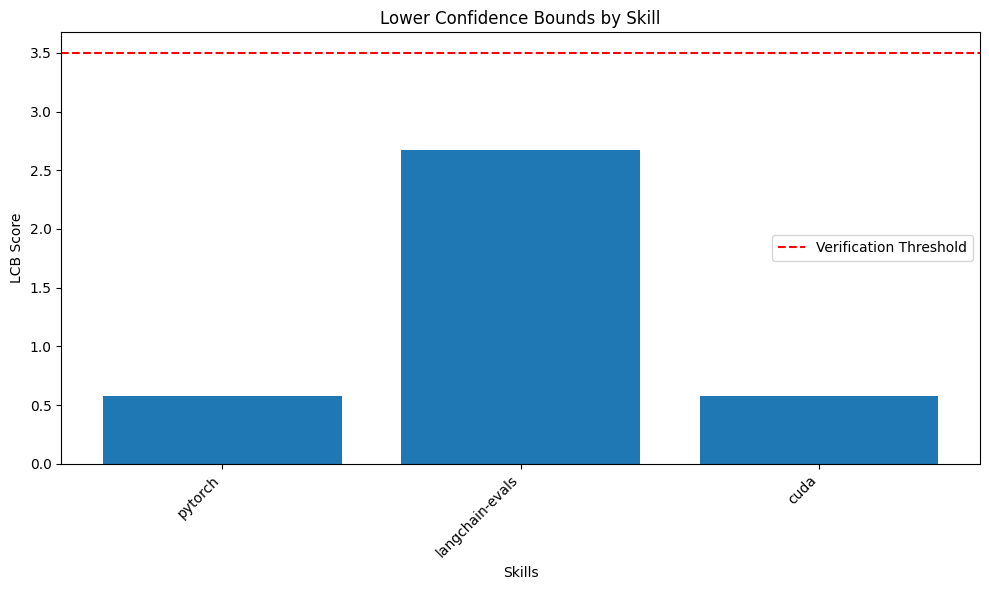


=== Turn 8 ===

Next skill: langchain-evals
Question (4/5): What are the key steps to create and integrate a custom evaluation metric in langchain-evals for assessing the performance of a language model on a specific task, and how would you ensure its reliability?

Candidate answer:
To create and integrate a custom evaluation metric in langchain-evals, you would first define the metric function that computes the desired evaluation criteria based on the model's outputs and the expected results. Next, you would register this metric within the langchain-evals framework, ensuring it is properly linked to the evaluation process. To ensure reliability, you could validate the metric against a set of benchmark results and conduct thorough testing across diverse datasets to confirm its consistency and accuracy.

LLM score: 4/5
Reasoning: The response outlines the key steps to create and integrate a custom evaluation metric in langchain-evals, including defining the metric function and register

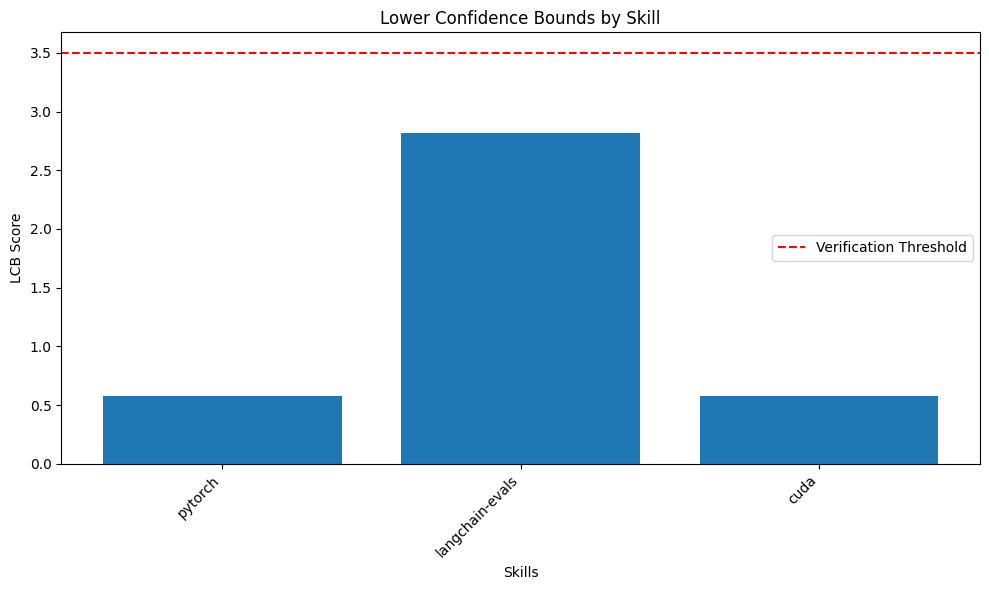


=== Turn 9 ===

Next skill: langchain-evals
Question (4/5): How would you implement a custom evaluation metric in langchain-evals specifically for measuring the F1 score of a language model's output, and what steps would you take to validate its performance?

Candidate answer:
To implement a custom evaluation metric for the F1 score in langchain-evals, I would define a new evaluation class that calculates precision, recall, and F1 score based on the model's outputs and the ground truth. To validate its performance, I would run the evaluation on a diverse set of test cases, compare the results against established benchmarks, and ensure that the metric aligns with the expected performance of the language model. Since I am not familiar with PyTorch or CUDA, I would focus on the logic of the evaluation rather than any underlying tensor operations.

LLM score: 3/5
Reasoning: The response correctly identifies the need to define a new evaluation class for calculating precision, recall, and F

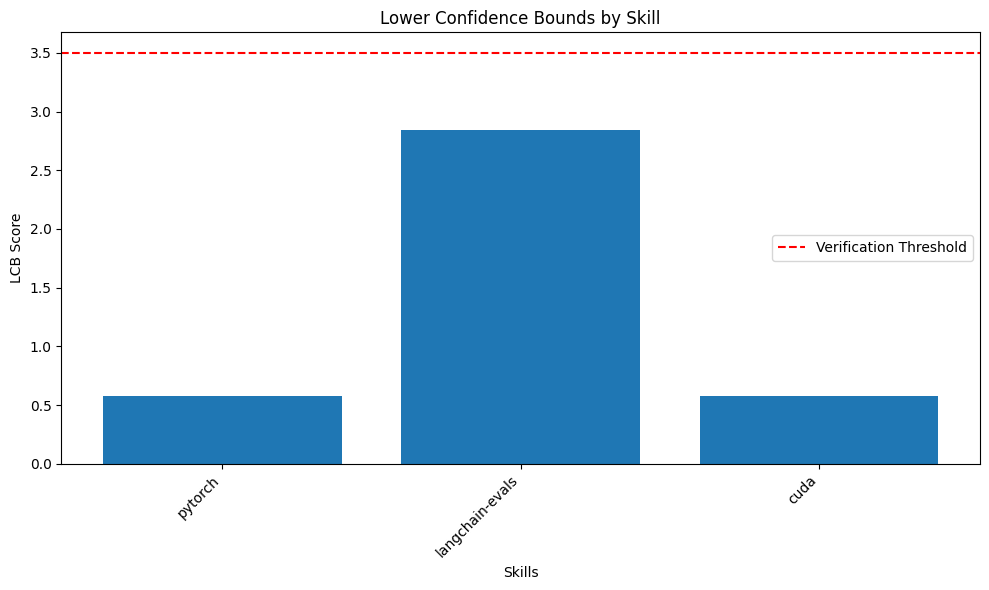


=== Turn 10 ===

Next skill: langchain-evals
Question (3/5): What are the essential components to consider when designing a custom evaluation metric in langchain-evals for a specific language model task, and how would you ensure that the metric is both effective and reliable?

Candidate answer:
When designing a custom evaluation metric in langchain-evals, it's essential to consider the specific objectives of the language model task, the relevant performance indicators (like accuracy, precision, or recall), and the data distribution to ensure the metric aligns with the task's goals. To ensure effectiveness and reliability, I would implement thorough testing with diverse datasets and validate the metric against established benchmarks to confirm its consistency and relevance. Additionally, incorporating feedback from domain experts can help refine the metric further.

LLM score: 4/5
Reasoning: The response identifies key components such as objectives, performance indicators, and data dis

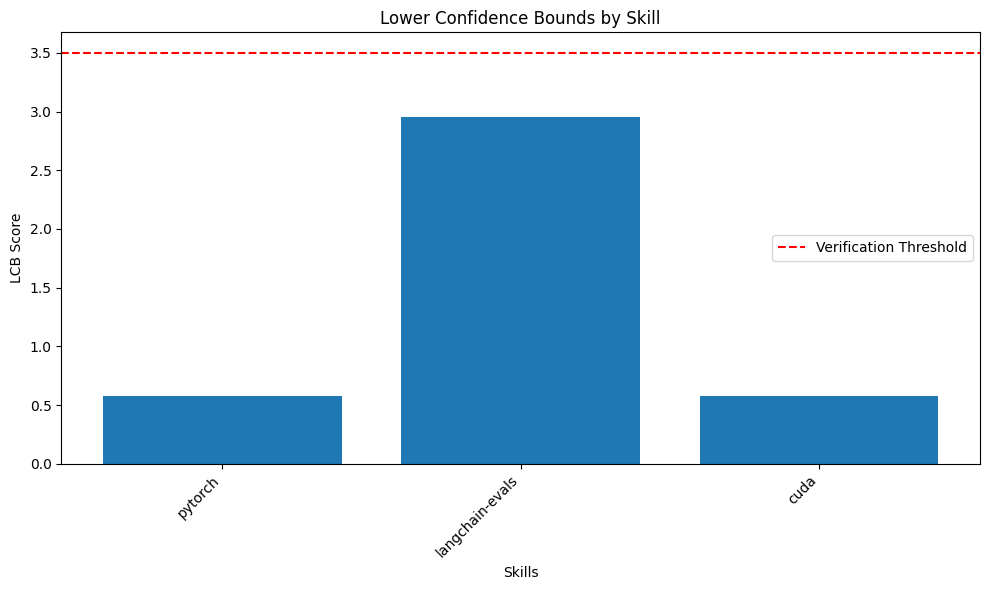

Interview complete per policy.


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional

from app.agents.interviewer.graph import build_graph, build_state
from app.agents.interviewer.nodes.grade import grade_node
from app.agents.interviewer.nodes.update import update_node
from app.agents.interviewer.nodes.decide import decide_node
from app.core.llm import get_llm

# Rebuild a fresh state so we can replay multiple turns
state = build_state(
    skills,
    max_turns,
    min_questions,
    verification_threshold,
    z_value,
    ucb_c,
    spans_map,
)

workflow = build_graph(interrupt_after=["ask"])

def plot_skill_lcbs(state):
    """Plot the LCB values for each skill."""
    skill_data = []
    for summary in state["skill_summaries"]:
        skill_data.append({
            'skill': summary['skill'],
            'lcb': summary['lcb'],
            'mean': summary['mean'],
            'verified': summary['skill'] in state.get('verified_skills', [])
        })
    
    df = pd.DataFrame(skill_data)
    plt.figure(figsize=(10, 6))
    bars = plt.bar(df['skill'], df['lcb'])
    plt.axhline(y=verification_threshold, color='r', linestyle='--', label='Verification Threshold')
    
    # Color verified skills differently
    for i, bar in enumerate(bars):
        if df['verified'].iloc[i]:
            bar.set_color('green')
    
    plt.title('Lower Confidence Bounds by Skill')
    plt.xlabel('Skills')
    plt.ylabel('LCB Score')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

async def run_turn(state, answer: Optional[str] = None):
    """Advance the graph to the next question, capture an answer, then grade/update."""
    try:
        turn_state = await workflow.ainvoke(state)
    except GraphInterrupt as interrupt:
        turn_state = dict(interrupt.state.values)

    question = turn_state["current_question"]
    if question is None:
        print("Interview already complete per policy.")
        return turn_state

    print(f"\nNext skill: {question.skill}")
    print(f"Question ({question.difficulty}/5): {question.text}")

    if answer is None:
        llm = get_llm(temperature=0.3)
        msg = await llm.ainvoke(
            f"You are a candidate in a technical interview. Answer this interview question as someone proficient in "
            f"langchain-evals but unfamiliar with pytorch and cuda. If the question involves pytorch/cuda concepts you don't know, "
            f"be honest about your limitations rather than attempting solutions. Keep your response focused and under 3 sentences.\n\n"
            f"Question: {question.text}"
            f"{question.text}"
        )
        answer = msg.content.strip()

    print("\nCandidate answer:")
    print(answer)

    turn_state["pending_answer"] = answer
    turn_state = await grade_node(turn_state)
    grade = turn_state["last_grade"]
    print(f"\nLLM score: {grade.score}/5")
    print(f"Reasoning: {grade.reasoning}")

    turn_state = update_node(turn_state)
    render_skills(turn_state)
    plot_skill_lcbs(turn_state)
    return turn_state

async def simulate_interview(state, max_turns: int = 6):
    for turn in range(max_turns):
        print(f"\n=== Turn {turn + 1} ===")
        state = await run_turn(state)
        if decide_node(state).goto != "select":
            print("Interview complete per policy.")
            break
    return state

state = await simulate_interview(state, max_turns=10)
